In [58]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os

%matplotlib inline
from sklearn.utils import shuffle
import cv2

from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers

from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

from keras.layers import Flatten




# CREAZIONE DEL MODELLO **RESNET50**
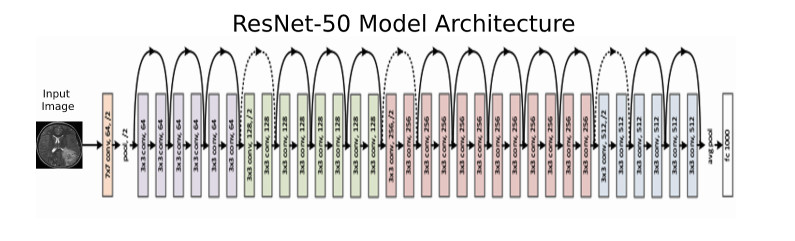

Definisco una serie di costanti che serviranno in seguito durante l'istanziamento, compilazione e fit della ret.

In [59]:
#Numero di classi
NUM_CLASSES = 100


IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE deve essere sempre < NUM_EPOCHS
NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 3

STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

BATCH_SIZE_TESTING = 1

BATCH_SIZE= 128

In [60]:
from keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Model

Instanziamento della ResNet50. 
Per quanto riguarda i pesi abbiamo utilizzato quelli della collezione di Imagenet.
Infatti Keras contiene un numero di modelli già pre-addestrati per task di Image Classification, proprio utlizzando i dati contenuti in Imagenet.

In [62]:
model = applications.resnet50.ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights='imagenet', input_shape=(224,224,3))

x= model.output
x = Flatten()(x)
x= Dense(units=100, activation='softmax')(x)
model= Model(inputs=model.input, outputs=x)


In [63]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Compilazione del modello.
Abbiamo compilato il modello utilizzando come **optimizer** lo **stochastic gradient descent**, in modo tale da rendere la discesa del gradiente più fair senza problemi di rallentamento o divergenza.
Infine come metrica per valutare la loss, come consuetudine, abbiamo utilizzato l'**accuracy**.


In [64]:
from tensorflow.keras import optimizers


sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
#adam = optimizers.Adam(lr=0.1)
model.compile(loss=OBJECTIVE_FUNCTION,
            optimizer=sgd,
            metrics=[LOSS_METRICS])

In [65]:
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Creazione del train e validation set dallo stream delle immagini contenute nelle rispettive cartelle.

In [66]:
from keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator()

image_size = IMAGE_RESIZE

train_generator = data_generator.flow_from_directory(
        '/content/gdrive/MyDrive/LandMarkDataset/train/',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical'
        )

validation_generator = data_generator.flow_from_directory(
        '/content/gdrive/MyDrive/LandMarkDataset/val/',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical'
        ) 

Found 11412 images belonging to 100 classes.
Found 1385 images belonging to 100 classes.


In [67]:
train='/content/gdrive/MyDrive/LandMarkDataset/train/'
valid='/content/gdrive/MyDrive/LandMarkDataset/val/'


Fit del modello, con un numero di epoche pari a 50.

In [68]:
fit_history = model.fit(
        train_generator,
        steps_per_epoch=np.ceil(float(len(train)) / float(BATCH_SIZE)),
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=np.ceil(float(len(valid)) / float(BATCH_SIZE))
        )


Epoch 1/50
1/1 [==============================] - 109s 109s/step - loss: 5.1441 - accuracy: 0.0100 - val_loss: 5.1710 - val_accuracy: 0.0300
Epoch 2/50
1/1 [==============================] - 111s 111s/step - loss: 4.9940 - accuracy: 0.0100 - val_loss: 5.3579 - val_accuracy: 0.0100
Epoch 3/50
1/1 [==============================] - 99s 99s/step - loss: 4.8645 - accuracy: 0.0300 - val_loss: 4.9858 - val_accuracy: 0.0500
Epoch 4/50
1/1 [==============================] - 97s 97s/step - loss: 4.5689 - accuracy: 0.0500 - val_loss: 4.8128 - val_accuracy: 0.0500
Epoch 5/50
1/1 [==============================] - 97s 97s/step - loss: 4.5251 - accuracy: 0.0800 - val_loss: 4.8695 - val_accuracy: 0.0300
Epoch 6/50
1/1 [==============================] - 99s 99s/step - loss: 4.0560 - accuracy: 0.1600 - val_loss: 4.8285 - val_accuracy: 0.0800
Epoch 7/50
1/1 [==============================] - 98s 98s/step - loss: 3.8780 - accuracy: 0.2200 - val_loss: 4.5305 - val_accuracy: 0.0700
Epoch 8/50
1/1 [=======

Plot per visionare meglio l'andamento dell'**accuracy** e della loss epoca per epoca.

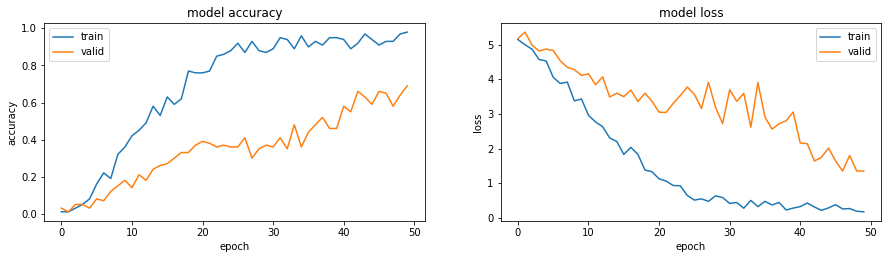

In [69]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

Generazione del test set dalla corrispondente cartella.

In [70]:
test_generator = data_generator.flow_from_directory(
    directory = '/content/gdrive/MyDrive/LandMarkDataset/test/',
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 1519 images belonging to 100 classes.


Effettuiamo il **predict** del modello sulle immagini contenute nel test set.

In [71]:
# bisogna resettare prima di ogni predizione
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1519/1519 [==============================] - 337s 221ms/step


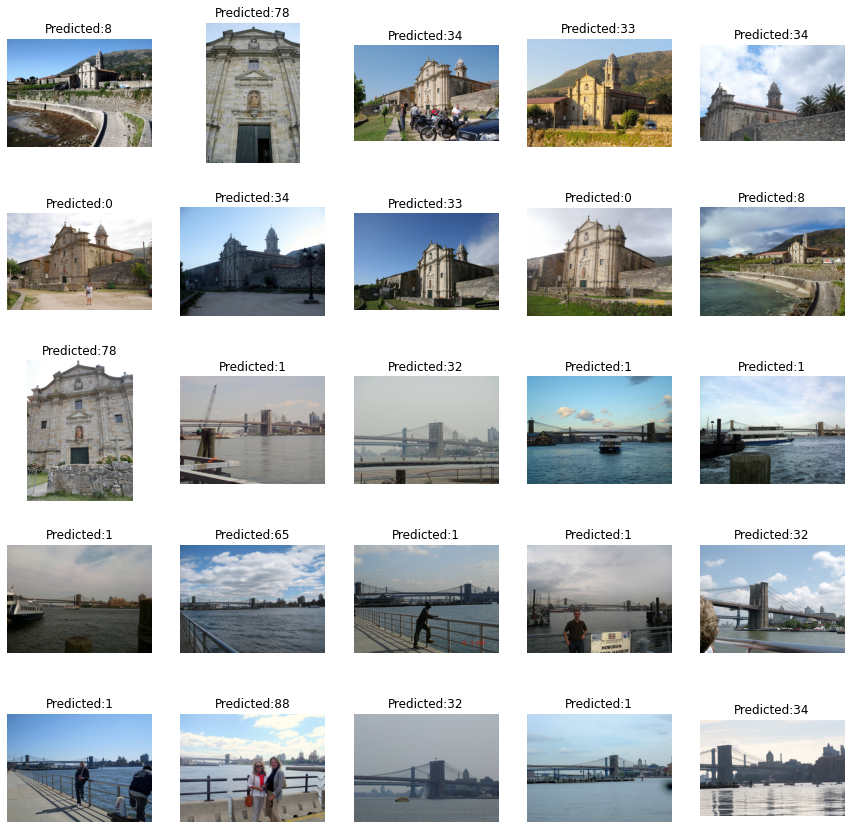

In [72]:
TEST_DIR = '/content/gdrive/MyDrive/LandMarkDataset/test/'
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
   
    predicted_class = predicted_class_indices[i]

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()

PLOT DELLA **PRECISIONE** E **RECALL** RU OGNI CLASSE, CON CONSEGUENTE VALORE DELL' **ACCURACY** RIPORTATA DALLA RETE.


In [73]:
predicted_class=np.argmax(pred, axis=1)
print(predicted_class)

[ 8 78 34 ... 99 32 99]


In [74]:
true_classes = test_generator.classes
class_labels= list(test_generator.class_indices.keys())

from sklearn.metrics import classification_report
report = classification_report(true_classes, predicted_class, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

       10018       0.17      0.18      0.17        11
       10094       1.00      0.62      0.77        16
       10602       0.92      0.73      0.81        15
       11300       0.94      1.00      0.97        16
       11378       1.00      0.31      0.48        16
       11491       1.00      0.14      0.25        14
       11499       1.00      0.88      0.93        16
       11513       1.00      0.54      0.70        13
        1168       0.22      0.94      0.36        16
       11716       0.83      0.83      0.83        12
       11719       0.92      0.65      0.76        17
       11750       0.59      1.00      0.74        17
       11849       0.27      1.00      0.43        15
       11967       0.92      0.80      0.86        15
       12181       0.82      0.64      0.72        14
       12204       1.00      0.65      0.79        17
       12360       1.00      0.31      0.48        16
       12481       1.00    